In [1]:
import torch
import os
from torchvision import datasets, transforms

# 加载数据
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

# Check if the dataset exists, if not, download it
data_root = './data'
if not os.path.exists(data_root) or not os.listdir(data_root):
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)
else:
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)
    # 检查第一个样本
image, label = train_dataset[0]
print(f"Pixel Range: Min = {image.min().item()}, Max = {image.max().item()}")

Pixel Range: Min = 0.0, Max = 1.0


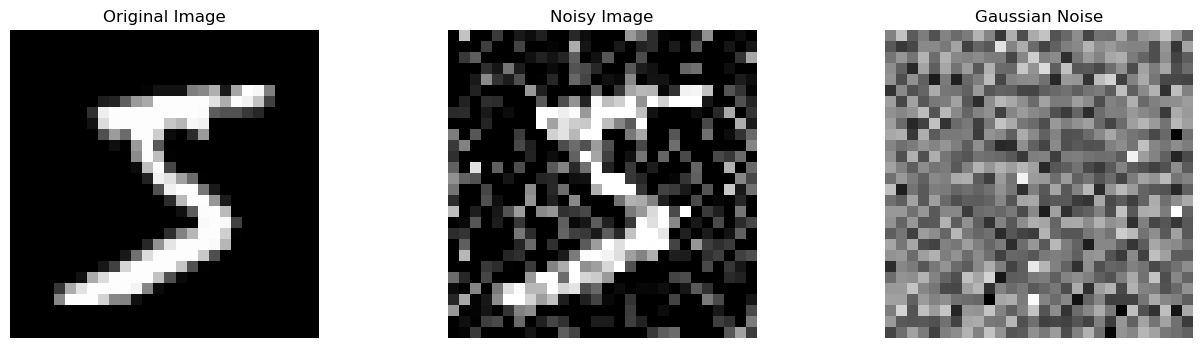

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os

# Set data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
])

# Get the first image
image, label = train_dataset[0]  # Get the first image and label

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=0.3):
    noisy_image = image + torch.randn_like(image) * std + mean
    return torch.clamp(noisy_image, 0., 1.)  # Clamp pixel values between [0, 1]

# Get the noisy image
noisy_image = add_gaussian_noise(image)

# Function to generate Gaussian noise
def generate_gaussian_noise(image, std=0.3):
    noise = torch.randn_like(image) * std  # Generate Gaussian noise
    return noise

# Generate the noise image
noise_image = generate_gaussian_noise(image)

# Plot images
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# Plot the original image
ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Plot the noisy image
ax[1].imshow(noisy_image.squeeze(), cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

# Plot the noise image
ax[2].imshow(noise_image.squeeze(), cmap='gray')
ax[2].set_title('Gaussian Noise')
ax[2].axis('off')

plt.show()

In [3]:
# main code
import odl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Set hyperparameters
batch_size = 128
learning_rate = 0.005
num_epochs = 5
data_root = './data'

# Radon Transform Settings
image_size = 28  # MNIST images are 28x28
num_angles = 30  # Number of projection angles
angle_partition = odl.uniform_partition(0, np.pi, num_angles)
detector_partition = odl.uniform_partition(-image_size // 2, image_size // 2, image_size)

space = odl.uniform_discr([-14, -14], [14, 14], (image_size, image_size), dtype='float32')
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_transform = odl.tomo.RayTransform(space, geometry)

# Filtered Back Projection (FBP) operator
fbp_op = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.8)

# Function to apply Radon Transform
def apply_radon_transform(tensor):
    array = tensor.numpy().squeeze()  # Convert to NumPy, shape: [28, 28]
    sinogram = ray_transform(array).asarray()  # Apply Radon transform
    return torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # Add channel dim

# Function to reconstruct image using FBP
def reconstruct_fbp(sinogram):
    sinogram_odl = ray_transform.range.element(sinogram)  # 使用 ray_transform.range.element
    reconstruction = fbp_op(sinogram_odl).asarray()
    return reconstruction

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.3):
    noisy_image = image + torch.randn_like(image) * std + mean
    return torch.clamp(noisy_image, 0., 1.)  # Clamp pixel values between [0, 1]
    
# Preprocessing and MNIST loading
transform = transforms.Compose([
    transforms.ToTensor()  # Convert PIL image to tensor in [0, 1]
])

if not os.path.exists(data_root) or not os.listdir(data_root):
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)
else:
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)

Visualizing noisy samples from train dataset:


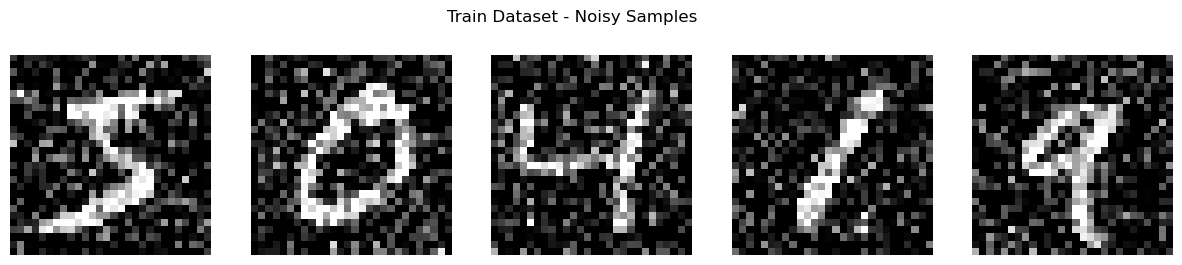

Visualizing noisy samples from test dataset:


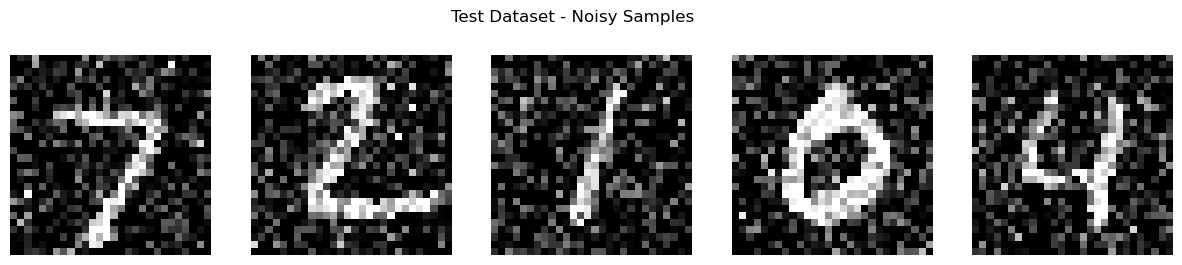

In [4]:
def map_to_minus_one_to_one(x):
    return x * 2 - 1  # [0, 1] -> [-1, 1]

class NoisySinogramDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, _ = self.original_dataset[idx]
        noisy_image = add_gaussian_noise(image)  # Add Gaussian noise
        noisy_sinogram = apply_radon_transform(noisy_image)  # Radon transform
        clean_sinogram = apply_radon_transform(image)  # Radon transform without noise

        # Map images and sinograms to [-1, 1]
        noisy_image = map_to_minus_one_to_one(noisy_image)
        noisy_sinogram = map_to_minus_one_to_one(noisy_sinogram)
        clean_sinogram = map_to_minus_one_to_one(clean_sinogram)

        return noisy_image, noisy_sinogram, clean_sinogram

train_dataset = NoisySinogramDataset(train_dataset)
test_dataset = NoisySinogramDataset(test_dataset)
# Visualization checkpoint: Noisy dataset samples
def visualize_samples(dataset, num_samples=5, title="Samples"):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, _, _ = dataset[i]
        axes[i].imshow(image.squeeze(0), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize noisy samples from train and test datasets
print("Visualizing noisy samples from train dataset:")
visualize_samples(train_dataset, num_samples=5, title="Train Dataset - Noisy Samples")

print("Visualizing noisy samples from test dataset:")
visualize_samples(test_dataset, num_samples=5, title="Test Dataset - Noisy Samples")

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN for denoising
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model = DenoisingCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=learning_rate)

# Train the denoising network
for epoch in range(num_epochs):
    denoising_model.train()
    for batch_idx, (_, noisy_sinograms, clean_sinograms) in enumerate(train_loader):  # 忽略 noisy_image
        noisy_sinograms, clean_sinograms = noisy_sinograms.to(device), clean_sinograms.to(device)

        # Forward pass
        denoised_sinograms = denoising_model(noisy_sinograms)
        loss = criterion(denoised_sinograms, clean_sinograms)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 1.8538
Epoch [2/5], Loss: 1.8506
Epoch [3/5], Loss: 1.7262
Epoch [4/5], Loss: 1.8446
Epoch [5/5], Loss: 1.5611


Visualizing sinograms and reconstructions during testing:


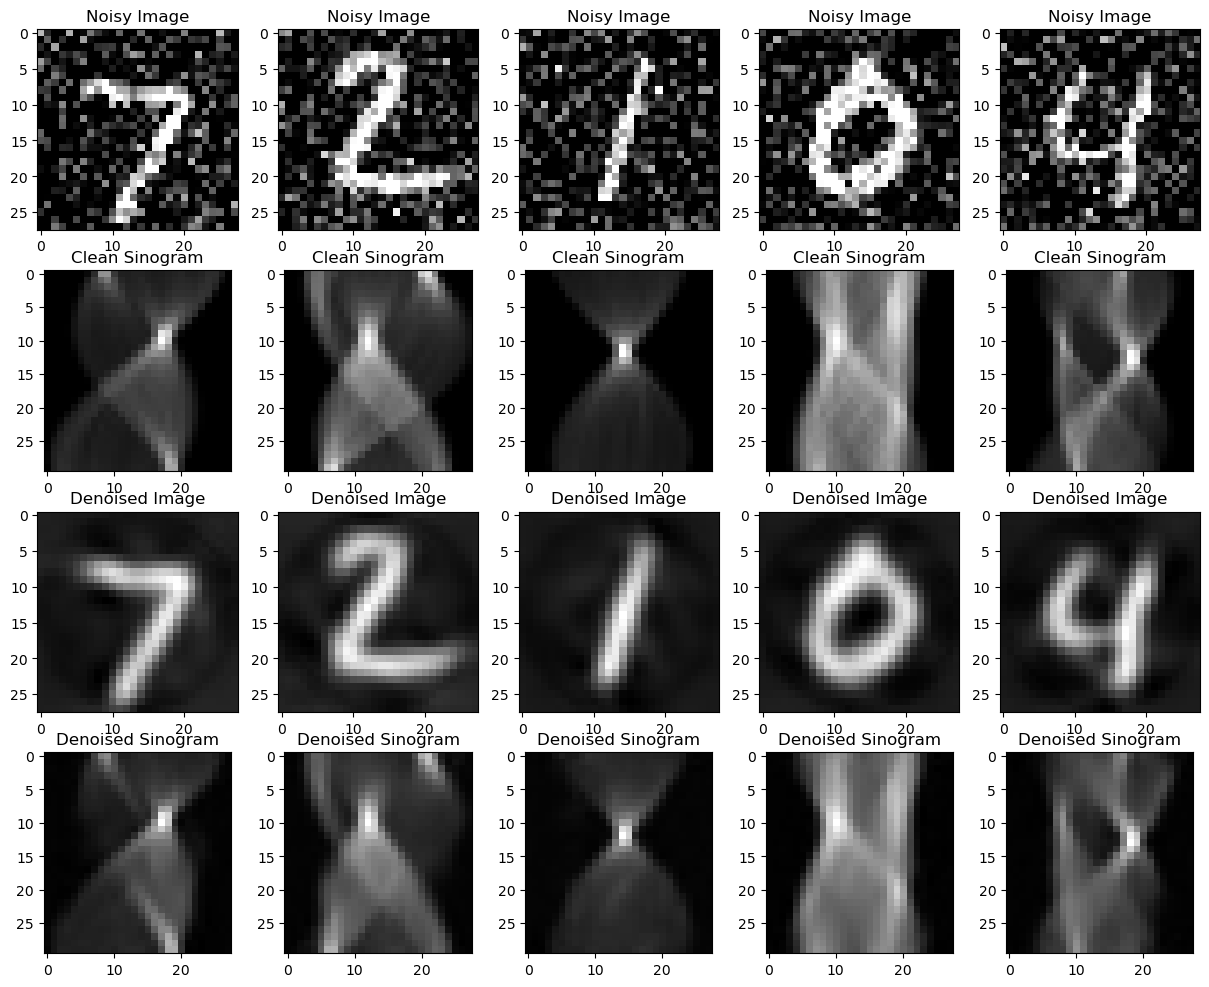

In [6]:
# Test the denoising network
denoising_model.eval()
with torch.no_grad():
    for batch_idx, (noisy_images, noisy_sinograms, clean_sinograms) in enumerate(test_loader):
        noisy_images = noisy_images.to(device)
        noisy_sinograms = noisy_sinograms.to(device)
        denoised_sinograms = denoising_model(noisy_sinograms)

        # Visualization checkpoint: During testing
        print("Visualizing sinograms and reconstructions during testing:")
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        for i in range(5):
            axes[0, i].imshow(noisy_images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0, i].set_title("Noisy Image")
            axes[1, i].imshow(clean_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1, i].set_title("Clean Sinogram")
            axes[2, i].imshow(reconstruct_fbp(denoised_sinograms[i].cpu().numpy().squeeze()), cmap='gray')
            axes[2, i].set_title("Denoised Image")
            axes[3, i].imshow(denoised_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[3, i].set_title("Denoised Sinogram")
        plt.show()

        break  # Visualize one batch only

In [7]:
# UNet model definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(1, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.middle = self.conv_block(128, 256)
        self.decoder3 = self.conv_block(256, 128)
        self.decoder2 = self.conv_block(128, 64)
        self.decoder1 = self.conv_block(64, 32)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        
        # Middle
        middle = self.middle(enc3)
        
        # Decoder
        dec3 = self.decoder3(middle)
        dec2 = self.decoder2(dec3)
        dec1 = self.decoder1(dec2)
        
        # Final output
        out = self.final_conv(dec1)
        return out

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=learning_rate)

# Train the denoising network
for epoch in range(num_epochs):
    denoising_model.train()
    for batch_idx, (_, noisy_sinograms, clean_sinograms) in enumerate(train_loader):  # 忽略 noisy_image
        noisy_sinograms, clean_sinograms = noisy_sinograms.to(device), clean_sinograms.to(device)

        # Forward pass
        denoised_sinograms = denoising_model(noisy_sinograms)
        loss = criterion(denoised_sinograms, clean_sinograms)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 27.5941
Epoch [2/5], Loss: 28.2728
Epoch [3/5], Loss: 28.6163
Epoch [4/5], Loss: 24.8602
Epoch [5/5], Loss: 29.5161


Visualizing sinograms and reconstructions during testing:


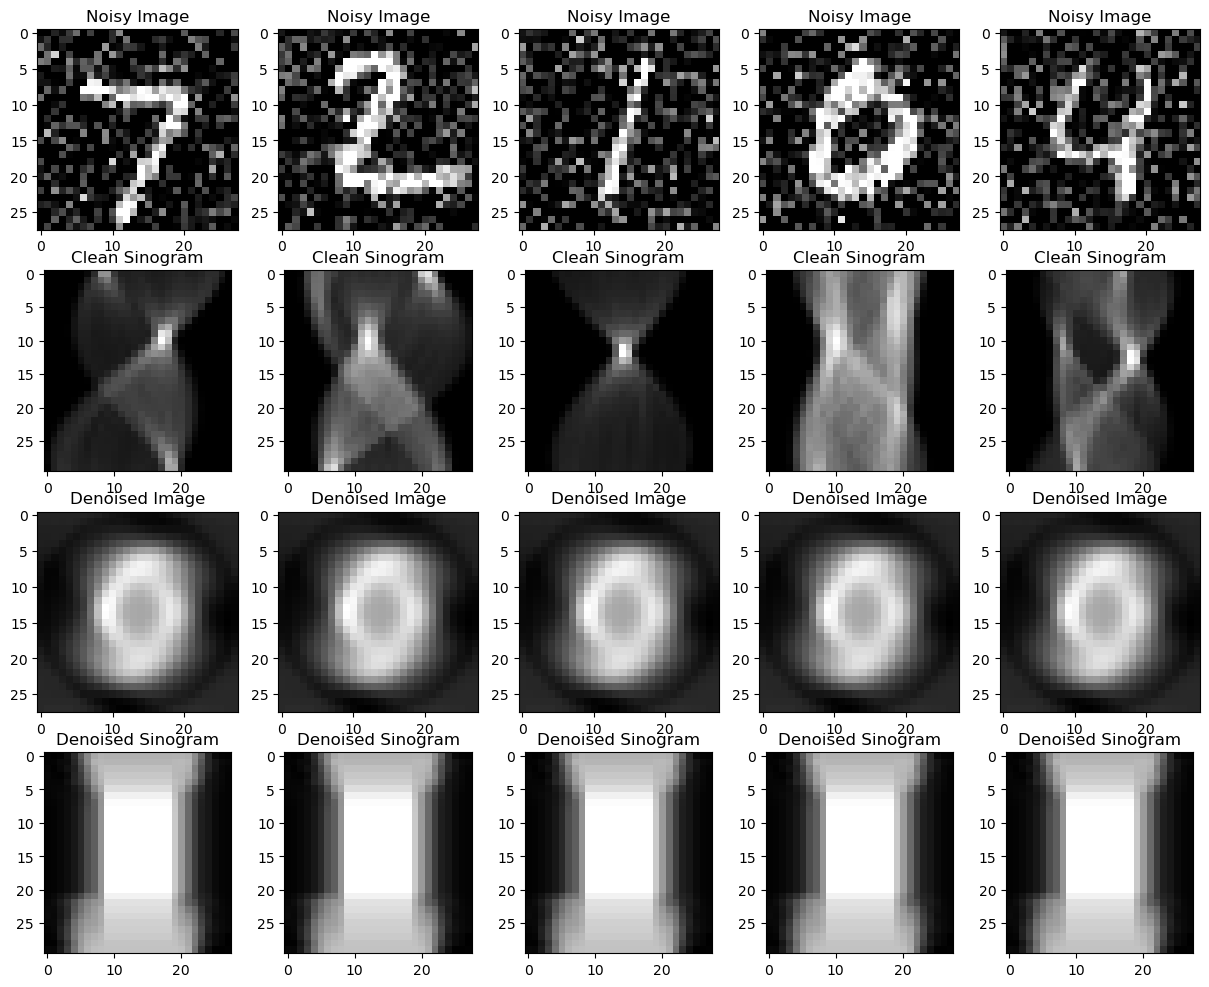

In [8]:
# Test the denoising network
denoising_model.eval()
with torch.no_grad():
    for batch_idx, (noisy_images, noisy_sinograms, clean_sinograms) in enumerate(test_loader):
        noisy_images = noisy_images.to(device)
        noisy_sinograms = noisy_sinograms.to(device)
        denoised_sinograms = denoising_model(noisy_sinograms)

        # Visualization checkpoint: During testing
        print("Visualizing sinograms and reconstructions during testing:")
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        for i in range(5):
            axes[0, i].imshow(noisy_images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0, i].set_title("Noisy Image")
            axes[1, i].imshow(clean_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1, i].set_title("Clean Sinogram")
            axes[2, i].imshow(reconstruct_fbp(denoised_sinograms[i].cpu().numpy().squeeze()), cmap='gray')
            axes[2, i].set_title("Denoised Image")
            axes[3, i].imshow(denoised_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[3, i].set_title("Denoised Sinogram")
        plt.show()

        break  # Visualize one batch only

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ResNet block definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Shortcut connection
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.relu(x + residual)

# ResNet model definition
class ResNetDenoising(nn.Module):
    def __init__(self, num_blocks=3):
        super(ResNetDenoising, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.residual_blocks = self.make_residual_blocks(64, num_blocks)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def make_residual_blocks(self, channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.residual_blocks(x)
        x = self.final_conv(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model = ResNetDenoising(num_blocks=3).to(device)  # You can adjust the number of residual blocks
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=learning_rate)

# Train the denoising network
for epoch in range(num_epochs):
    denoising_model.train()
    for batch_idx, (_, noisy_sinograms, clean_sinograms) in enumerate(train_loader):  # 忽略 noisy_image
        noisy_sinograms, clean_sinograms = noisy_sinograms.to(device), clean_sinograms.to(device)

        # Forward pass
        denoised_sinograms = denoising_model(noisy_sinograms)
        loss = criterion(denoised_sinograms, clean_sinograms)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [ ]:
# Test the denoising network
denoising_model.eval()
with torch.no_grad():
    for batch_idx, (noisy_images, noisy_sinograms, clean_sinograms) in enumerate(test_loader):
        noisy_images = noisy_images.to(device)
        noisy_sinograms = noisy_sinograms.to(device)
        denoised_sinograms = denoising_model(noisy_sinograms)

        # Visualization checkpoint: During testing
        print("Visualizing sinograms and reconstructions during testing:")
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        for i in range(5):
            axes[0, i].imshow(noisy_images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0, i].set_title("Noisy Image")
            axes[1, i].imshow(clean_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1, i].set_title("Clean Sinogram")
            axes[2, i].imshow(reconstruct_fbp(denoised_sinograms[i].cpu().numpy().squeeze()), cmap='gray')
            axes[2, i].set_title("Denoised Image")
            axes[3, i].imshow(denoised_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[3, i].set_title("Denoised Sinogram")
        plt.show()

        break  # Visualize one batch only